In [1]:
import numpy as np 
import matplotlib.pyplot as plt 


import sys
import os
sys.path.insert(0, os.path.abspath(".."))
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import jax
import jax.numpy as jnp 

from skimage.filters import window 
#jax.config.update("jax_platform_name", "cpu")


from kltpicker_3d.tests.gaussian_spectrum import *
from kltpicker_3d.spectral_estimation import *

In [2]:
K = 100
T = -np.log(1e-15)/30
N = 32 
M = 2*N - 1 

sigma = 1 
w = 2*5*sigma 
w0 = w / M

def cfftn(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))


grid = np.arange(-(N-1),N)
i,j,k  = np.meshgrid(grid,grid,grid)
omega_x, omega_y, omega_z = i*w0, j*w0, k*w0
omega_r = np.sqrt(omega_x ** 2 + omega_y ** 2 + omega_z ** 2)
H = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(- omega_r ** 2 / (2*sigma ** 2)) * (1 + 0.1 * np.cos(10*omega_r))
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

window = np.bartlett(M)
samples = np.zeros((K,N,N,N))
spectrum = np.zeros((K, M,M,M))
for k in range(K):
    noise = np.random.normal(size=(M,M,M))
    sample = np.fft.ifftn(np.fft.fftn(noise) * normalized_H)
    samples[k,...] = sample[:N,:N,:N]
    spectrum[k,...] = cfftn(sample * window)

spectrum = np.mean(np.abs(spectrum),axis=0)
spectrum /= np.linalg.norm(spectrum) 

samples = samples.real 

S = H / np.linalg.norm(H)

/tmp/ipykernel_1583184/2905426403.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]
/tmp/ipykernel_1583184/2905426403.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[k,...] = cfftn(sample * window)


In [4]:
max_d = int(np.floor(N/2))
samples = jnp.array(samples)
p3 = estimate_isotropic_powerspectrum_tensor(samples,max_d)

In [5]:
p3 /= jnp.linalg.norm(p3)

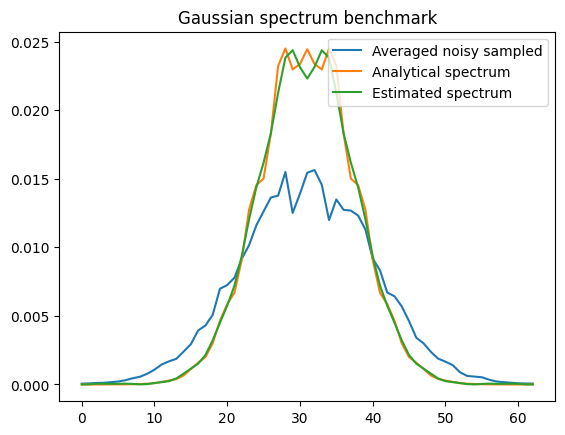

In [12]:
plt.plot(spectrum[N,N,:], label='Averaged noisy sampled')
plt.plot(S[N,N,:], label='Analytical spectrum')
plt.plot(p3[N,N,:], label='Estimated spectrum')
plt.title("Gaussian spectrum benchmark")
plt.legend();

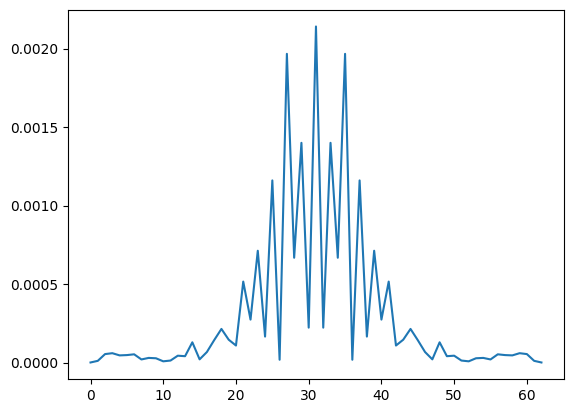

In [9]:
errors = np.abs(S[N,N,:] - p3[N,N,:])
plt.plot(errors);

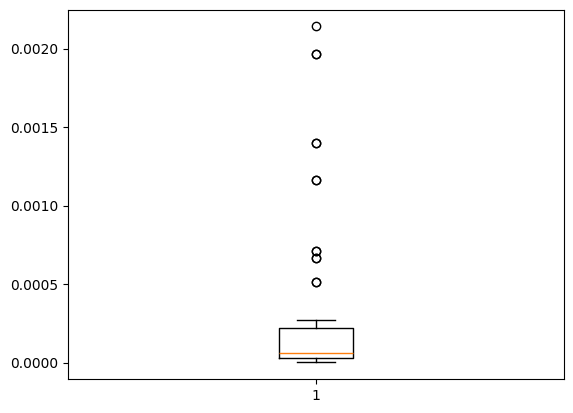

In [11]:
plt.boxplot(errors);

In [2]:
p3, true_spectrum, avg_spectrum = benchmark_gaussian_spectrum(32, 100)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/gaussian_spectrum.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


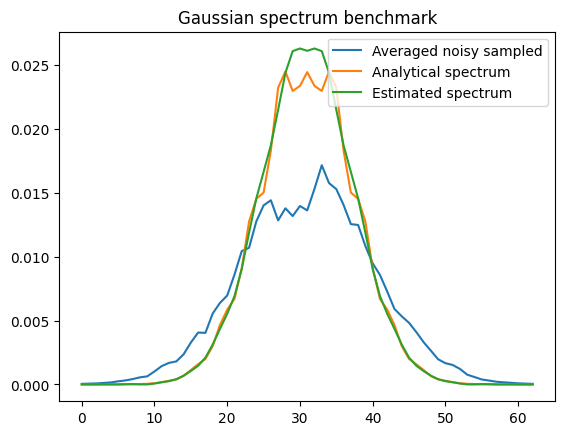

In [6]:
plt.plot(avg_spectrum[32,32,:], label='Averaged noisy sampled')
plt.plot(true_spectrum[32,32,:], label='Analytical spectrum')
plt.plot(p3[32,32,:], label='Estimated spectrum')
plt.title("Gaussian spectrum benchmark")
plt.legend();

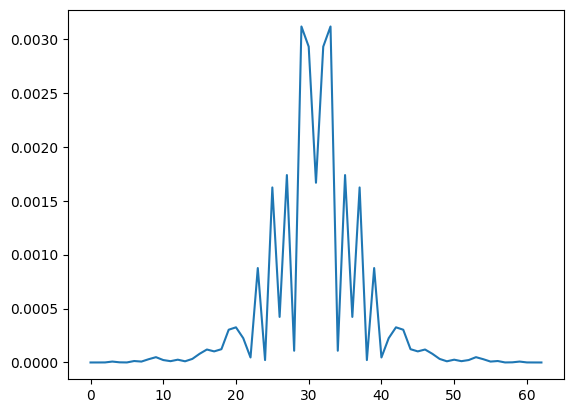

In [9]:
errors = np.abs(true_spectrum[32,32,:] - p3[32,32,:])
plt.plot(errors);